## Applicazione ad uno scenario realistico: Wine Classification


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Lettura dataset
from sklearn.datasets import load_wine
wine = load_wine()

In [3]:
# Creazione DataFrame
df = pd.DataFrame(wine.data, columns=wine.feature_names)
df['target'] = wine.target


Distribuzione dei target:
target
1    0.398876
0    0.331461
2    0.269663
Name: proportion, dtype: float64


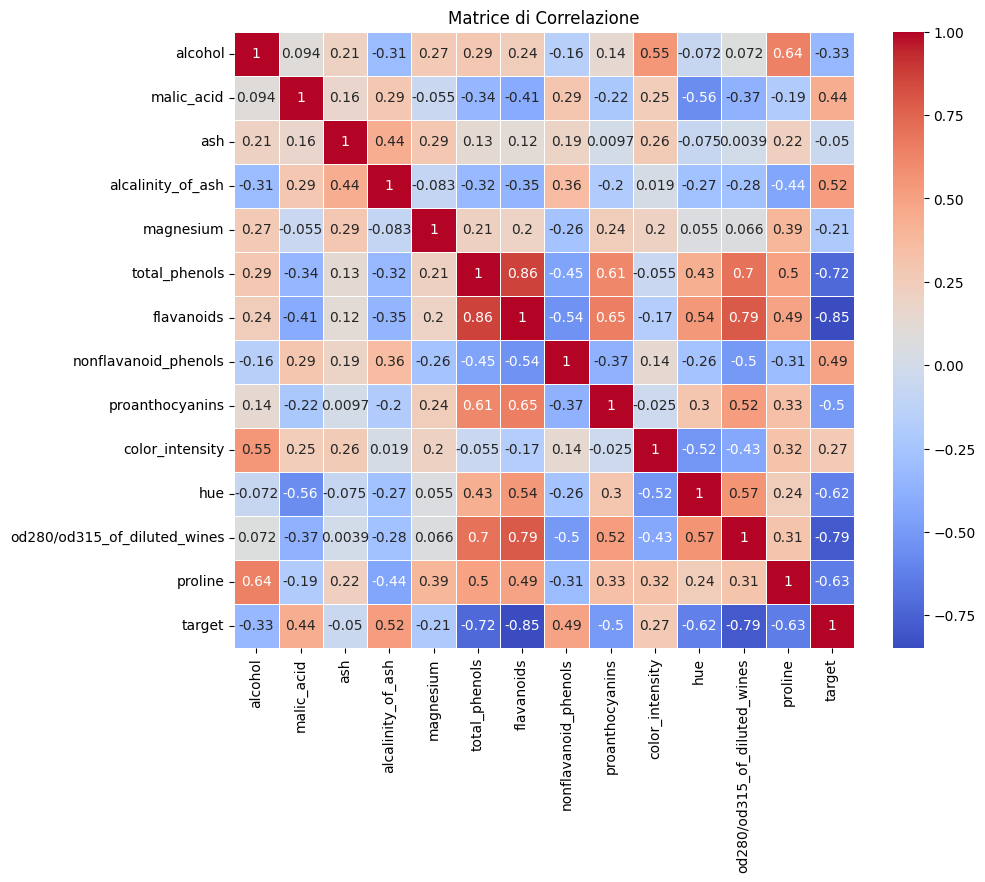

In [4]:
# Verifica della distribuzione della variabile target
print("\nDistribuzione dei target:")
print(df['target'].value_counts(normalize=True))


plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matrice di Correlazione')
plt.show()
features = df.columns[:-1] 


In [5]:
# Vogliamo un problema binario, quindi selezioniamo solo due classi
df = df[df['target'] != 2]
df['target'] = df['target'].map({0: 0, 1: 1})  # Rinominiamo le classi per chiarezza
print("\nDistribuzione dei target dopo la modifica:")
print(df['target'].value_counts(normalize=True))



Distribuzione dei target dopo la modifica:
target
1    0.546154
0    0.453846
Name: proportion, dtype: float64


In [6]:
df

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,12.07,2.16,2.17,21.0,85.0,2.60,2.65,0.37,1.35,2.76,0.86,3.28,378.0,1
126,12.43,1.53,2.29,21.5,86.0,2.74,3.15,0.39,1.77,3.94,0.69,2.84,352.0,1
127,11.79,2.13,2.78,28.5,92.0,2.13,2.24,0.58,1.76,3.00,0.97,2.44,466.0,1
128,12.37,1.63,2.30,24.5,88.0,2.22,2.45,0.40,1.90,2.12,0.89,2.78,342.0,1


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
np.random.seed(42)
# Separazione feature e target
X = df.drop('target', axis=1)
y = df['target']
# Divisione in training e test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Dimensioni del training set:", X_train.shape)
print("Dimensioni del test set:", X_test.shape)

Dimensioni del training set: (104, 13)
Dimensioni del test set: (26, 13)


In [8]:
import numpy as np
import matplotlib.pyplot as plt

class LinearSVM:
    """
    Implementazione di SVM lineare utilizzando l'algoritmo SMO (Sequential Minimal Optimization)
    per risolvere il problema duale del Lagrangiano.
    
    Questo algoritmo risolve il problema duale:
    max Σ α_i - (1/2) Σ Σ α_i α_j y_i y_j (x_i · x_j)
    vincoli: Σ α_i y_i = 0, 0 ≤ α_i ≤ C
    
    Parametri:
    -----------
    C : float, default=1.0
        Parametro di regolarizzazione per il margine morbido.
    tol : float, default=1e-3
        Tolleranza per i criteri di convergenza.
    max_passes : int, default=5
        Numero massimo di passate senza cambiamenti significativi.
    max_iter : int, default=1000
        Numero massimo di iterazioni.
    """
    
    def __init__(self, C=1.0, tol=1e-3, max_passes=10, max_iter=10000):
        self.C = C
        self.tol = tol
        self.max_passes = max_passes
        self.max_iter = max_iter
        self.alphas = None
        self.b = 0
        self.w = None
        self.support_vector_indices = None
        self.support_vectors = None
        self.support_vector_labels = None
        self.errors = None
    
    def _compute_error(self, i):
        """Calcola l'errore per il punto i"""
        f_i = np.dot(self.w, self.X[i]) + self.b
        return f_i - self.y[i]
    
    def _compute_bounds(self, i, j):
        """Calcola i limiti L e H per gli alphas"""
        if self.y[i] != self.y[j]:
            L = max(0, self.alphas[j] - self.alphas[i])
            H = min(self.C, self.C + self.alphas[j] - self.alphas[i])
        else:
            L = max(0, self.alphas[i] + self.alphas[j] - self.C)
            H = min(self.C, self.alphas[i] + self.alphas[j])
        return L, H
    
    def _select_second_alpha(self, i):
        """Seleziona il secondo alpha per l'ottimizzazione"""
        errors = self.errors.copy()
        # Escludiamo l'errore di i
        valid_indices = np.arange(len(errors)) != i
        errors_valid = errors[valid_indices]
        indices_valid = np.arange(len(errors))[valid_indices]
        
        # Troviamo l'indice con il massimo errore rispetto a i
        if self.errors[i] > 0:
            j = indices_valid[np.argmin(errors_valid)]
        else:
            j = indices_valid[np.argmax(errors_valid)]
        
        return j
    
    def fit(self, X, y):
        """
        Addestra il modello SVM sui dati di training.
        
        Parametri:
        ----------
        X : array-like, shape (n_samples, n_features)
            Training vectors.
        y : array-like, shape (n_samples,)
            Target values, deve contenere -1 e 1 o 0 e 1.
        
        Returns:
        --------
        self : oggetto
            Ritorna self.
        """
        n_samples, n_features = X.shape
        
        # Convertiamo le etichette in -1/1
        self.y_original = y.copy()
        self.y = np.where(y <= 0, -1, 1)
        self.X = X
        
        # Inizializziamo gli alpha, w e b
        self.alphas = np.zeros(n_samples)
        self.w = np.zeros(n_features)
        self.b = 0
        
        # Inizializziamo gli errori
        self.errors = np.zeros(n_samples)
        for i in range(n_samples):
            self.errors[i] = self._compute_error(i)
        
        print("Inizio addestramento SVM con algoritmo SMO...")
        
        # Implementazione dell'algoritmo SMO
        num_changed = 0
        examine_all = True
        passes = 0
        
        while (passes < self.max_passes) and (num_changed > 0 or examine_all):
            num_changed = 0
            
            if examine_all:
                # Esaminiamo tutti i punti
                for i in range(n_samples):
                    num_changed += self._examine_example(i)
            else:
                # Esaminiamo solo i punti con 0 < alpha < C
                non_bound_indices = np.where((self.alphas > 0) & (self.alphas < self.C))[0]
                for i in non_bound_indices:
                    num_changed += self._examine_example(i)
            
            if examine_all:
                examine_all = False
            elif num_changed == 0:
                examine_all = True
            
            passes += 1
            if passes % 10 == 0:
                print(f"Passata {passes}, {num_changed} cambiamenti")
        
        # Identifichiamo i support vector
        sv_indices = np.where(self.alphas > self.tol)[0]
        self.support_vector_indices = sv_indices
        self.support_vectors = X[sv_indices]
        self.support_vector_labels = self.y[sv_indices]
        
        print(f"Addestramento completato in {passes} steps!")
        print(f"Numero di support vectors: {len(sv_indices)} su {n_samples} punti ({len(sv_indices)/n_samples*100:.1f}%)")
        print(f"Norma del vettore w: {np.linalg.norm(self.w):.6f}")
        
        return self
    
    def _examine_example(self, i):
        """Esamina un esempio e aggiorna gli alpha se necessario"""
        y_i = self.y[i]
        alpha_i = self.alphas[i]
        E_i = self.errors[i]
        r_i = E_i * y_i
        
        # Verifico se viola le condizioni KKT
        if ((r_i < -self.tol and alpha_i < self.C) or (r_i > self.tol and alpha_i > 0)):
            # Provo a ottimizzare con un secondo alpha
            j = self._select_second_alpha(i)
            return self._take_step(i, j)
        
        return 0
    
    def _take_step(self, i, j):
        """Esegue l'ottimizzazione per la coppia di alpha (i, j)"""
        if i == j:
            return 0
        
        alpha_i = self.alphas[i]
        alpha_j = self.alphas[j]
        y_i = self.y[i]
        y_j = self.y[j]
        E_i = self.errors[i]
        E_j = self.errors[j]
        
        # Calcolo i limiti L e H
        L, H = self._compute_bounds(i, j)
        if L == H:
            return 0
        
        # Calcolo eta = x_i·x_i + x_j·x_j - 2x_i·x_j
        eta = np.dot(self.X[i], self.X[i]) + np.dot(self.X[j], self.X[j]) - 2 * np.dot(self.X[i], self.X[j])
        
        if eta <= 0:
            # Questo non dovrebbe accadere con kernel positivi definiti
            return 0
        
        # Calcolo il nuovo valore di alpha_j
        alpha_j_new = alpha_j + y_j * (E_i - E_j) / eta
        
        # Limitiamo alpha_j ai vincoli
        if alpha_j_new > H:
            alpha_j_new = H
        elif alpha_j_new < L:
            alpha_j_new = L
        
        # Se il cambiamento è troppo piccolo, non facciamo nulla
        if abs(alpha_j_new - alpha_j) < 1e-5:
            return 0
        
        # Calcoliamo alpha_i_new
        alpha_i_new = alpha_i + y_i * y_j * (alpha_j - alpha_j_new)
        
        # Aggiorniamo il bias
        b_old = self.b
        
        # Aggiorniamo b in modo che gli errori siano 0 per i punti i e j
        b1 = b_old - E_i - y_i * (alpha_i_new - alpha_i) * np.dot(self.X[i], self.X[i]) - \
             y_j * (alpha_j_new - alpha_j) * np.dot(self.X[i], self.X[j])
             
        b2 = b_old - E_j - y_i * (alpha_i_new - alpha_i) * np.dot(self.X[i], self.X[j]) - \
             y_j * (alpha_j_new - alpha_j) * np.dot(self.X[j], self.X[j])
        
        if 0 < alpha_i_new < self.C:
            self.b = b1
        elif 0 < alpha_j_new < self.C:
            self.b = b2
        else:
            self.b = (b1 + b2) / 2
        
        # Aggiorniamo il vettore dei pesi
        self.w = self.w + y_i * (alpha_i_new - alpha_i) * self.X[i] + y_j * (alpha_j_new - alpha_j) * self.X[j]
        
        # Aggiorniamo gli alpha
        self.alphas[i] = alpha_i_new
        self.alphas[j] = alpha_j_new
        
        # Aggiorniamo gli errori
        for k in range(len(self.errors)):
            self.errors[k] = self._compute_error(k)
        
        return 1
    
    def predict(self, X):
        """
        Predice la classe per i punti X.
        
        Parametri:
        ----------
        X : array-like, shape (n_samples, n_features)
            Punti da classificare.
            
        Returns:
        --------
        y_pred : array, shape (n_samples,)
            Classi predette (-1 o 1).
        """
        return np.sign(self.decision_function(X))
    
    def predict_class(self, X):
        """
        Predice la classe originale (0 o 1) per i punti X.
        
        Parametri:
        ----------
        X : array-like, shape (n_samples, n_features)
            Punti da classificare.
            
        Returns:
        --------
        y_pred : array, shape (n_samples,)
            Classi predette (0 o 1).
        """
        raw_predictions = self.predict(X)
        # Convertiamo da -1/1 a 0/1
        if np.any(self.y_original == 0):
            return np.where(raw_predictions < 0, 0, 1)
        else:
            return raw_predictions
    
    def decision_function(self, X):
        """
        Calcola i valori della funzione di decisione.
        
        Parametri:
        ----------
        X : array-like, shape (n_samples, n_features)
            Punti da valutare.
            
        Returns:
        --------
        decision : array, shape (n_samples,)
            Valori della funzione di decisione.
        """
        return np.dot(X, self.w) + self.b
    
    def plot_decision_boundary(self, X, y, feature_indices=(0, 1), title="Confine di decisione SVM"):
        """
        Visualizza il confine di decisione SVM per due feature selezionate.
        
        Parametri:
        -----------
        X : array-like di shape (n_samples, n_features)
            Dataset
        y : array-like di shape (n_samples,)
            Etichette, in {0, 1} o {-1, 1}
        feature_indices : tuple, default=(0, 1)
            Indici delle due feature da visualizzare
        title : str
            Titolo del grafico
        """
        # Convertiamo le etichette 0/1 in -1/1 se necessario
        y_binary = np.where(y <= 0, -1, 1)
        
        # Estraiamo le due feature
        X_plot = X[:, feature_indices]
        
        # Creiamo una griglia per visualizzare il confine di decisione
        x_min, x_max = X_plot[:, 0].min() - 1, X_plot[:, 0].max() + 1
        y_min, y_max = X_plot[:, 1].min() - 1, X_plot[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                             np.arange(y_min, y_max, 0.02))
        
        # Prepariamo i punti della griglia
        grid_points = np.c_[xx.ravel(), yy.ravel()]
        
        # Se abbiamo più di due feature, dobbiamo aggiungere le altre feature
        if X.shape[1] > 2:
            # Calcoliamo i valori medi delle altre feature
            mean_values = X.mean(axis=0)
            
            # Creiamo una matrice di punti completa
            full_grid_points = np.zeros((grid_points.shape[0], X.shape[1]))
            for i in range(X.shape[1]):
                if i == feature_indices[0]:
                    full_grid_points[:, i] = grid_points[:, 0]
                elif i == feature_indices[1]:
                    full_grid_points[:, i] = grid_points[:, 1]
                else:
                    full_grid_points[:, i] = mean_values[i]
            
            # Calcoliamo i valori della funzione di decisione
            Z = self.decision_function(full_grid_points)
        else:
            # Se abbiamo solo due feature, possiamo usare direttamente i punti della griglia
            Z = self.decision_function(grid_points)
        
        # Riformattiamo Z per la visualizzazione
        Z = Z.reshape(xx.shape)
        
        plt.figure(figsize=(10, 8))
        
        # Visualizziamo il confine di decisione e i margini
        plt.contourf(xx, yy, Z, levels=[-1, 0, 1], alpha=0.5, 
                     colors=('skyblue', 'white', 'salmon'))
        plt.contour(xx, yy, Z, levels=[-1, 0, 1], colors=('blue', 'black', 'red'), 
                    linewidths=(1, 2, 1))
        
        # Visualizziamo i punti di training
        plt.scatter(X_plot[y_binary == 1, 0], X_plot[y_binary == 1, 1], 
                   c='red', marker='o', edgecolors='k', label='Classe 1')
        plt.scatter(X_plot[y_binary == -1, 0], X_plot[y_binary == -1, 1], 
                   c='blue', marker='s', edgecolors='k', label='Classe 0')
        
        # Evidenziamo i support vector
        if hasattr(self, 'support_vector_indices') and self.support_vector_indices is not None:
            plt.scatter(X_plot[self.support_vector_indices, 0], X_plot[self.support_vector_indices, 1], 
                       s=100, facecolors='none', edgecolors='green', linewidths=2, 
                       label='Support Vectors')
        
        plt.title(title)
        plt.xlabel(f'Feature {feature_indices[0]}')
        plt.ylabel(f'Feature {feature_indices[1]}')
        plt.legend()
        plt.tight_layout()
        plt.show()

In [9]:
class KernelSVM:
    """
    Implementazione di SVM con supporto per diversi kernel non lineari,
    utilizzando l'algoritmo SMO (Sequential Minimal Optimization).
    
    Questo algoritmo risolve il problema duale:
    max Σ α_i - (1/2) Σ Σ α_i α_j y_i y_j K(x_i, x_j)
    vincoli: Σ α_i y_i = 0, 0 ≤ α_i ≤ C
    
    Parametri:
    -----------
    C : float, default=1.0
        Parametro di regolarizzazione per il margine morbido.
    kernel : str, default='linear'
        Tipo di kernel da utilizzare. Opzioni: 'linear', 'poly', 'rbf', 'sigmoid'.
    degree : int, default=3
        Grado del kernel polinomiale (usato solo se kernel='poly').
    gamma : float, default='scale'
        Coefficiente del kernel. Usato per 'rbf', 'poly' e 'sigmoid'.
        Se 'scale', gamma = 1 / (n_features * X.var()).
        Se 'auto', gamma = 1 / n_features.
    coef0 : float, default=0.0
        Termine indipendente nel kernel polinomiale e sigmoide.
    tol : float, default=1e-3
        Tolleranza per i criteri di convergenza.
    max_passes : int, default=5
        Numero massimo di passate senza cambiamenti significativi.
    max_iter : int, default=1000
        Numero massimo di iterazioni per l'ottimizzazione di una coppia di alpha.
    random_state : int, default=None
        Seed per il generatore di numeri casuali.
    """
    
    def __init__(self, C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0,
                 tol=1e-3, max_passes=5, max_iter=1000, random_state=None):
        self.C = C
        self.kernel_type = kernel
        self.degree = degree
        self.gamma = gamma
        self.coef0 = coef0
        self.tol = tol
        self.max_passes = max_passes
        self.max_iter = max_iter
        self.random_state = random_state
        
        # Attributi che verranno inizializzati durante il fit
        self.alphas = None
        self.b = 0.0
        self.support_vector_indices = None
        self.support_vectors = None
        self.support_vector_labels = None
        self.support_vector_alphas = None
        self.X = None
        self.y = None
        self.y_original = None
        self.kernel_matrix = None
        self._gamma = None  # gamma calcolato
        self.w = None  # Solo per kernel lineare
        self.n_samples = None
        self.n_features = None
        self.errors = None
    
    def _compute_gamma(self, X):
        """Calcola il valore di gamma in base all'opzione selezionata"""
        n_features = X.shape[1]
        if self.gamma == 'scale':
            return 1.0 / (n_features * X.var())
        elif self.gamma == 'auto':
            return 1.0 / n_features
        else:
            return self.gamma
    
    def _linear_kernel(self, x1, x2):
        """Kernel lineare: K(x1, x2) = x1 · x2"""
        return np.dot(x1, x2)
    
    def _polynomial_kernel(self, x1, x2):
        """Kernel polinomiale: K(x1, x2) = (gamma * x1 · x2 + coef0)^degree"""
        return (self._gamma * np.dot(x1, x2) + self.coef0) ** self.degree
    
    def _rbf_kernel(self, x1, x2):
        """Kernel RBF (Gaussian): K(x1, x2) = exp(-gamma * ||x1 - x2||^2)"""
        return np.exp(-self._gamma * np.sum((x1 - x2) ** 2))
    
    def _sigmoid_kernel(self, x1, x2):
        """Kernel sigmoide: K(x1, x2) = tanh(gamma * x1 · x2 + coef0)"""
        return np.tanh(self._gamma * np.dot(x1, x2) + self.coef0)
    
    def _kernel_function(self, x1, x2):
        """Seleziona il kernel appropriato"""
        if self.kernel_type == 'linear':
            return self._linear_kernel(x1, x2)
        elif self.kernel_type == 'poly':
            return self._polynomial_kernel(x1, x2)
        elif self.kernel_type == 'rbf':
            return self._rbf_kernel(x1, x2)
        elif self.kernel_type == 'sigmoid':
            return self._sigmoid_kernel(x1, x2)
        else:
            raise ValueError(f"Kernel '{self.kernel_type}' non supportato")
    
    def _compute_kernel_matrix(self, X):
        """Calcola la matrice del kernel per tutti i punti"""
        n_samples = X.shape[0]
        K = np.zeros((n_samples, n_samples))
        
        for i in range(n_samples):
            for j in range(i, n_samples):
                K_ij = self._kernel_function(X[i], X[j])
                K[i, j] = K_ij
                K[j, i] = K_ij  # La matrice è simmetrica
        
        return K
    
    def _compute_error(self, i):
        """Calcola l'errore per il punto i"""
        if self.kernel_type == 'linear' and self.w is not None:
            # Per kernel lineare usiamo direttamente w·x + b
            f_i = np.dot(self.X[i], self.w) + self.b
        else:
            # Per kernel non lineari usiamo la formula duale
            f_i = self.b
            for j in range(len(self.alphas)):
                if self.alphas[j] > 0:  # Solo i support vector contribuiscono
                    f_i += self.alphas[j] * self.y[j] * self.kernel_matrix[j, i]
        
        return f_i - self.y[i]
    
    def _compute_bounds(self, i, j):
        """Calcola i limiti L e H per gli alphas"""
        if self.y[i] != self.y[j]:
            L = max(0, self.alphas[j] - self.alphas[i])
            H = min(self.C, self.C + self.alphas[j] - self.alphas[i])
        else:
            L = max(0, self.alphas[i] + self.alphas[j] - self.C)
            H = min(self.C, self.alphas[i] + self.alphas[j])
        return L, H
    
    def _select_second_alpha(self, i):
        """Seleziona il secondo alpha per l'ottimizzazione"""
        errors = self.errors.copy()
        valid_indices = np.arange(len(errors)) != i
        errors_valid = errors[valid_indices]
        indices_valid = np.arange(len(errors))[valid_indices]
        
        # Troviamo l'indice con il massimo errore rispetto a i
        if self.errors[i] > 0:
            j = indices_valid[np.argmin(errors_valid)]
        else:
            j = indices_valid[np.argmax(errors_valid)]
        
        return j
    
    def fit(self, X, y):
        """
        Addestra il modello SVM sui dati di training.
        
        Parametri:
        ----------
        X : array-like, shape (n_samples, n_features)
            Training vectors.
        y : array-like, shape (n_samples,)
            Target values, deve contenere -1 e 1 o 0 e 1.
        
        Returns:
        --------
        self : oggetto
            Ritorna self.
        """
        # Inizializzazione
        if self.random_state is not None:
            np.random.seed(self.random_state)
            
        self.n_samples, self.n_features = X.shape
        
        # Convertiamo le etichette in -1/1
        self.y_original = y.copy()
        self.y = np.where(y <= 0, -1, 1)
        self.X = X
        
        # Calcoliamo gamma
        self._gamma = self._compute_gamma(X)
        
        # Calcola la matrice del kernel
        print(f"Calcolo della matrice del kernel {self.kernel_type}...")
        self.kernel_matrix = self._compute_kernel_matrix(X)
        
        # Inizializziamo gli alpha, b e gli errori
        self.alphas = np.zeros(self.n_samples)
        self.b = 0
        self.errors = np.zeros(self.n_samples)
        
        for i in range(self.n_samples):
            self.errors[i] = self._compute_error(i)
        
        print(f"Inizio addestramento SVM con kernel {self.kernel_type} usando SMO...")
        
        # Implementazione dell'algoritmo SMO
        num_changed = 0
        examine_all = True
        passes = 0
        
        while (passes < self.max_passes) and (num_changed > 0 or examine_all):
            num_changed = 0
            
            if examine_all:
                # Esaminiamo tutti i punti
                for i in range(self.n_samples):
                    num_changed += self._examine_example(i)
            else:
                # Esaminiamo solo i punti con 0 < alpha < C
                non_bound_indices = np.where((self.alphas > 0) & (self.alphas < self.C))[0]
                for i in non_bound_indices:
                    num_changed += self._examine_example(i)
            
            if examine_all:
                examine_all = False
            elif num_changed == 0:
                examine_all = True
            
            passes += 1
            if passes % 5 == 0:
                print(f"Passata {passes}, {num_changed} cambiamenti")
        
        # Identifichiamo i support vector
        sv_indices = np.where(self.alphas > self.tol)[0]
        self.support_vector_indices = sv_indices
        self.support_vectors = X[sv_indices]
        self.support_vector_labels = self.y[sv_indices]
        self.support_vector_alphas = self.alphas[sv_indices]
        
        # Per kernel lineare, calcoliamo esplicitamente w
        if self.kernel_type == 'linear':
            self.w = np.zeros(self.n_features)
            for i in sv_indices:
                self.w += self.alphas[i] * self.y[i] * X[i]
        
        print(f"Addestramento completato in {passes} passate!")
        print(f"Numero di support vectors: {len(sv_indices)} su {self.n_samples} punti ({len(sv_indices)/self.n_samples*100:.1f}%)")
        
        if self.kernel_type == 'linear':
            print(f"Norma del vettore w: {np.linalg.norm(self.w):.6f}")
        
        return self
    
    def _examine_example(self, i):
        """Esamina un esempio e aggiorna gli alpha se necessario"""
        y_i = self.y[i]
        alpha_i = self.alphas[i]
        E_i = self.errors[i]
        r_i = E_i * y_i
        
        # Verifico se viola le condizioni KKT
        if ((r_i < -self.tol and alpha_i < self.C) or (r_i > self.tol and alpha_i > 0)):
            # Provo a ottimizzare con un secondo alpha
            j = self._select_second_alpha(i)
            return self._take_step(i, j)
        
        return 0
    
    def _take_step(self, i, j):
        """Esegue l'ottimizzazione per la coppia di alpha (i, j)"""
        if i == j:
            return 0
        
        alpha_i = self.alphas[i]
        alpha_j = self.alphas[j]
        y_i = self.y[i]
        y_j = self.y[j]
        E_i = self.errors[i]
        E_j = self.errors[j]
        
        # Calcolo i limiti L e H
        L, H = self._compute_bounds(i, j)
        if L == H:
            return 0
        
        # Calcolo eta = K_ii + K_jj - 2K_ij
        eta = self.kernel_matrix[i, i] + self.kernel_matrix[j, j] - 2 * self.kernel_matrix[i, j]
        
        if eta <= 0:
            # Questo può accadere con kernel non PSD (positivo semidefinito)
            return 0
        
        # Calcolo il nuovo valore di alpha_j
        alpha_j_new = alpha_j + y_j * (E_i - E_j) / eta
        
        # Limitiamo alpha_j ai vincoli
        if alpha_j_new > H:
            alpha_j_new = H
        elif alpha_j_new < L:
            alpha_j_new = L
        
        # Se il cambiamento è troppo piccolo, non facciamo nulla
        if abs(alpha_j_new - alpha_j) < 1e-5:
            return 0
        
        # Calcoliamo alpha_i_new
        alpha_i_new = alpha_i + y_i * y_j * (alpha_j - alpha_j_new)
        
        # Aggiorniamo il bias
        b_old = self.b
        
        # Aggiorniamo b in modo che gli errori siano 0 per i punti i e j
        b1 = b_old - E_i
        b1 -= y_i * (alpha_i_new - alpha_i) * self.kernel_matrix[i, i]
        b1 -= y_j * (alpha_j_new - alpha_j) * self.kernel_matrix[i, j]
             
        b2 = b_old - E_j
        b2 -= y_i * (alpha_i_new - alpha_i) * self.kernel_matrix[i, j]
        b2 -= y_j * (alpha_j_new - alpha_j) * self.kernel_matrix[j, j]
        
        if 0 < alpha_i_new < self.C:
            self.b = b1
        elif 0 < alpha_j_new < self.C:
            self.b = b2
        else:
            self.b = (b1 + b2) / 2
        
        # Aggiorniamo il vettore dei pesi per kernel lineare
        if self.kernel_type == 'linear' and self.w is not None:
            self.w = self.w + y_i * (alpha_i_new - alpha_i) * self.X[i] + y_j * (alpha_j_new - alpha_j) * self.X[j]
        
        # Aggiorniamo gli alpha
        self.alphas[i] = alpha_i_new
        self.alphas[j] = alpha_j_new
        
        # Aggiorniamo gli errori
        for k in range(len(self.errors)):
            self.errors[k] = self._compute_error(k)
        
        return 1
    
    def predict(self, X):
        """
        Predice la classe per i punti X.
        
        Parametri:
        ----------
        X : array-like, shape (n_samples, n_features)
            Punti da classificare.
            
        Returns:
        --------
        y_pred : array, shape (n_samples,)
            Classi predette (-1 o 1).
        """
        return np.sign(self.decision_function(X))
    
    def predict_class(self, X):
        """
        Predice la classe originale (0 o 1) per i punti X.
        
        Parametri:
        ----------
        X : array-like, shape (n_samples, n_features)
            Punti da classificare.
            
        Returns:
        --------
        y_pred : array, shape (n_samples,)
            Classi predette (0 o 1).
        """
        # Ottieni le previsioni -1/+1
        raw_predictions = self.predict(X)
        
        # Converti esplicitamente in 0/1
        # Assicuriamoci che il risultato contenga solo 0 e 1
        return np.where(raw_predictions <= 0, 0, 1)
    
    def decision_function(self, X):
        """
        Calcola i valori della funzione di decisione.
        
        Parametri:
        ----------
        X : array-like, shape (n_samples, n_features)
            Punti da valutare.
            
        Returns:
        --------
        decision : array, shape (n_samples,)
            Valori della funzione di decisione.
        """
        # Per kernel lineare, possiamo usare w·x + b
        if self.kernel_type == 'linear' and self.w is not None:
            return np.dot(X, self.w) + self.b
        
        # Per kernel non lineari, usiamo la formulazione duale
        n_samples = X.shape[0]
        decision = np.zeros(n_samples)
        
        for i in range(n_samples):
            decision[i] = self.b
            
            # Sommiamo solo sui support vector per efficienza
            for j, sv_idx in enumerate(self.support_vector_indices):
                decision[i] += self.support_vector_alphas[j] * self.support_vector_labels[j] * \
                              self._kernel_function(self.support_vectors[j], X[i])
        
        return decision
    
    def plot_decision_boundary(self, X, y, feature_indices=(0, 1), title=None):
        """
        Visualizza il confine di decisione SVM per due feature selezionate.
        
        Parametri:
        -----------
        X : array-like di shape (n_samples, n_features)
            Dataset
        y : array-like di shape (n_samples,)
            Etichette, in {0, 1} o {-1, 1}
        feature_indices : tuple, default=(0, 1)
            Indici delle due feature da visualizzare
        title : str, optional
            Titolo del grafico. Se None, viene generato automaticamente.
        """
        if title is None:
            title = f"Confine di decisione SVM con kernel {self.kernel_type}"
            if self.kernel_type == 'poly':
                title += f" (grado {self.degree})"
            elif self.kernel_type in ['rbf', 'sigmoid']:
                title += f" (gamma {self._gamma:.4f})"
        
        # Convertiamo le etichette 0/1 in -1/1 se necessario
        y_binary = np.where(y <= 0, -1, 1)
        
        # Estraiamo le due feature
        X_plot = X[:, feature_indices]
        
        # Creiamo una griglia per visualizzare il confine di decisione
        x_min, x_max = X_plot[:, 0].min() - 1, X_plot[:, 0].max() + 1
        y_min, y_max = X_plot[:, 1].min() - 1, X_plot[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                             np.arange(y_min, y_max, 0.02))
        
        # Prepariamo i punti della griglia
        grid_points = np.c_[xx.ravel(), yy.ravel()]
        
        # Se abbiamo più di due feature, dobbiamo aggiungere le altre feature
        if X.shape[1] > 2:
            # Calcoliamo i valori medi delle altre feature
            mean_values = X.mean(axis=0)
            
            # Creiamo una matrice di punti completa
            full_grid_points = np.zeros((grid_points.shape[0], X.shape[1]))
            for i in range(X.shape[1]):
                if i == feature_indices[0]:
                    full_grid_points[:, i] = grid_points[:, 0]
                elif i == feature_indices[1]:
                    full_grid_points[:, i] = grid_points[:, 1]
                else:
                    full_grid_points[:, i] = mean_values[i]
            
            # Calcoliamo i valori della funzione di decisione
            Z = self.decision_function(full_grid_points)
        else:
            # Se abbiamo solo due feature, possiamo usare direttamente i punti della griglia
            Z = self.decision_function(grid_points)
        
        # Riformattiamo Z per la visualizzazione
        Z = Z.reshape(xx.shape)
        
        plt.figure(figsize=(10, 8))
        
        # Visualizziamo il confine di decisione e i margini
        plt.contourf(xx, yy, Z, levels=[-1, 0, 1], alpha=0.5, 
                     colors=('skyblue', 'white', 'salmon'))
        plt.contour(xx, yy, Z, levels=[-1, 0, 1], colors=('blue', 'black', 'red'), 
                    linewidths=(1, 2, 1))
        
        # Visualizziamo i punti di training
        plt.scatter(X_plot[y_binary == 1, 0], X_plot[y_binary == 1, 1], 
                   c='red', marker='o', edgecolors='k', label='Classe 1')
        plt.scatter(X_plot[y_binary == -1, 0], X_plot[y_binary == -1, 1], 
                   c='blue', marker='s', edgecolors='k', label='Classe 0')
        
        # Evidenziamo i support vector
        if hasattr(self, 'support_vector_indices') and self.support_vector_indices is not None:
            sv_indices_plot = self.support_vector_indices
            plt.scatter(X_plot[sv_indices_plot, 0], X_plot[sv_indices_plot, 1], 
                       s=100, facecolors='none', edgecolors='green', linewidths=2, 
                       label='Support Vectors')
        
        plt.title(title)
        plt.xlabel(f'Feature {feature_indices[0]}')
        plt.ylabel(f'Feature {feature_indices[1]}')
        plt.legend()
        plt.tight_layout()
        plt.show()
    

In [10]:
X_train, X_test, y_train, y_test
# scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Inizio addestramento SVM con algoritmo SMO...
Addestramento completato in 3 steps!
Numero di support vectors: 10 su 104 punti (9.6%)
Norma del vettore w: 0.776188
Accuratezza del modello sul test: 0.9231


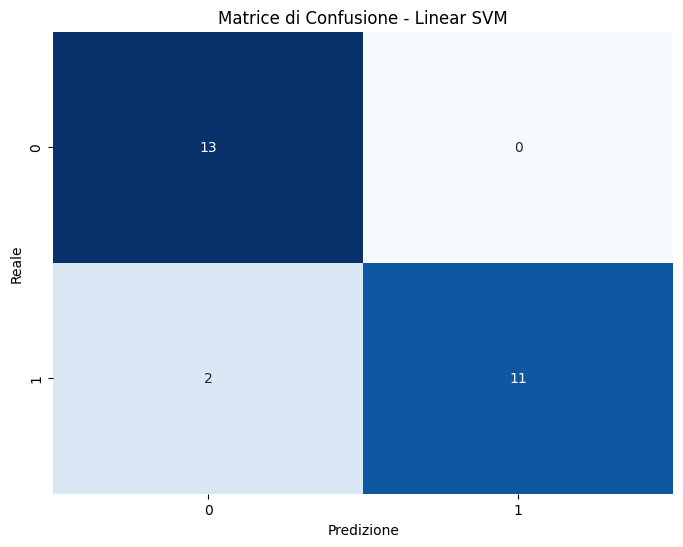

In [11]:
from sklearn.metrics import accuracy_score, confusion_matrix
SVM_linear = LinearSVM(C=0.1)
SVM_linear.fit(X_train_scaled, y_train.values)
y_pred_lin = SVM_linear.predict_class(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred_lin)
print(f"Accuratezza del modello sul test: {accuracy:.4f}")
# Visualizziamo la matrice di confusione
cm = confusion_matrix(y_test, y_pred_lin)
plt.figure(figsize=(8, 6))
plt.title('Matrice di Confusione - Linear SVM')
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predizione')
plt.ylabel('Reale')
plt.show()


Calcolo della matrice del kernel rbf...
Inizio addestramento SVM con kernel rbf usando SMO...
Passata 5, 6 cambiamenti
Addestramento completato in 5 passate!
Numero di support vectors: 104 su 104 punti (100.0%)
Accuratezza del modello sul test: 0.9615


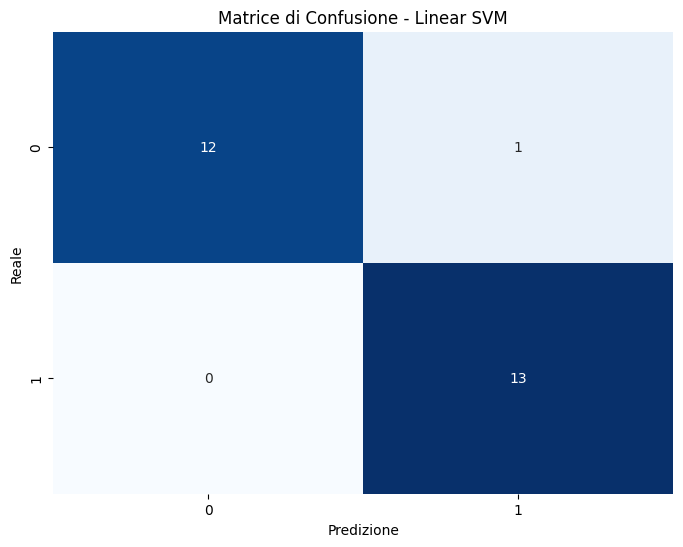

In [12]:

# Addestriamo SVM con kernel RBF per classificare le attività
SVM_kernel = KernelSVM(kernel='rbf', C=100, gamma=0.5, max_iter=10000)
SVM_kernel.fit(X_train_scaled, y_train.values)

# Facciamo predizioni sul test set
y_pred_kernel = SVM_kernel.predict_class(X_test_scaled)

# Calcoliamo l'accuratezza
accuracy = accuracy_score(y_test, y_pred_kernel)
print(f"Accuratezza del modello sul test: {accuracy:.4f}")

# Visualizziamo la matrice di confusione
cm = confusion_matrix(y_test, y_pred_kernel)
plt.figure(figsize=(8, 6))
plt.title('Matrice di Confusione - Linear SVM')
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predizione')
plt.ylabel('Reale')
plt.show()

## Usiamo tutte le classi ed estendiamo la classe

In [13]:
# Usiamo tutte le classi ed estendiamo la classe
wine = load_wine()
df = pd.DataFrame(wine.data, columns=wine.feature_names)
df['target'] = wine.target

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
np.random.seed(42)
# Separazione feature e target
X = df.drop('target', axis=1)
y = df['target']
# Divisione in training e test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Dimensioni del training set:", X_train.shape)
print("Dimensioni del test set:", X_test.shape)

Dimensioni del training set: (142, 13)
Dimensioni del test set: (36, 13)


In [15]:
class SVMMulticlassOVA:
    """
    Implementazione universale di SVM multiclasse usando l'approccio One-vs-All (OVA).
    Funziona con qualsiasi tipo di etichette (numeri, stringhe, etc.).
    """
    
    def __init__(self, svm_class=None, **svm_params):
        """
        Inizializzazione del modello
        
        Parametri:
        svm_class -- classe SVM da utilizzare (deve avere metodi fit, predict)
        svm_params -- parametri da passare al classificatore SVM
        """
        self.svm_class = svm_class  # Classe del classificatore SVM da utilizzare
        self.svm_params = svm_params
        self.classifiers = []
        self.classes = None
    
    def fit(self, X, y):
        """
        Addestra un classificatore SVM per ogni classe usando l'approccio OVA
        
        Parametri:
        X -- matrice delle feature
        y -- vettore delle etichette
        """
        # Memorizziamo le classi originali (qualsiasi tipo)
        self.classes = np.unique(y)
        n_classes = len(self.classes)
        
        print(f"Addestramento di {n_classes} classificatori SVM (OVA)...")
        
        # Addestriamo un classificatore per ogni classe
        for i, current_class in enumerate(self.classes):
            print(f"Classificatore {i+1}/{n_classes} per classe {current_class} vs resto")
            
            # Creiamo etichette binarie: 1 per la classe corrente, -1 per tutte le altre
            y_binary = np.ones(len(y)) * -1
            y_binary[y == current_class] = 1
            
            # Creiamo il classificatore
            if self.svm_class is None:
                # Se non è specificata una classe, utilizziamo LinearSVM
                classifier = LinearSVM(**self.svm_params)
            else:
                # Altrimenti usiamo la classe specificata
                classifier = self.svm_class(**self.svm_params)
            
            # Addestriamo il classificatore
            classifier.fit(X, y_binary)
            
            # Aggiungiamo il classificatore alla lista
            self.classifiers.append(classifier)
        
        print("Addestramento OVA completato!")
        return self
    
    def decision_function(self, X):
        """
        Calcola i punteggi di confidenza per ogni classe
        
        Parametri:
        X -- matrice delle feature
        
        Restituisce:
        scores -- matrice dei punteggi (n_samples, n_classes)
        """
        n_samples = X.shape[0]
        n_classes = len(self.classes)
        
        # Matrice dei punteggi: ogni riga è un campione, ogni colonna è una classe
        scores = np.zeros((n_samples, n_classes))
        
        # Calcoliamo i punteggi per ogni classificatore
        for i, classifier in enumerate(self.classifiers):
            # Prima proviamo con decision_function
            if hasattr(classifier, 'decision_function'):
                scores[:, i] = classifier.decision_function(X)
            else:
                # Se non disponibile, usiamo predict come fallback
                raw_predictions = classifier.predict(X)
                # Convertiamo in valori numerici se necessario
                if isinstance(raw_predictions[0], (str, bool)):
                    scores[:, i] = np.where(raw_predictions == 1, 1.0, -1.0)
                else:
                    scores[:, i] = raw_predictions
        
        return scores
    
    def predict(self, X):
        """
        Predice la classe con la massima confidenza
        
        Parametri:
        X -- matrice delle feature
        
        Restituisce:
        y_pred -- vettore delle classi predette
        """
        # Calcoliamo i punteggi per ogni classe
        scores = self.decision_function(X)
        
        # La classe predetta è quella con il punteggio più alto
        predicted_indices = np.argmax(scores, axis=1)
        
        # Mappiamo gli indici alle classi originali
        return self.classes[predicted_indices]
    
    def score(self, X, y):
        """
        Calcola l'accuratezza del modello
        
        Parametri:
        X -- matrice delle feature
        y -- vettore delle etichette reali
        
        Restituisce:
        accuracy -- accuratezza del modello
        """
        return accuracy_score(y, self.predict(X))
    
    def plot_confusion_matrix(self, X, y, title="Matrice di Confusione - SVM OVA"):
        """
        Visualizza la matrice di confusione
        
        Parametri:
        X -- matrice delle feature
        y -- vettore delle etichette reali
        title -- titolo del grafico
        """
        y_pred = self.predict(X)
        cm = confusion_matrix(y, y_pred)
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predizione')
        plt.ylabel('Reale')
        plt.title(title)
        plt.xticks(np.arange(len(self.classes)) + 0.5, self.classes)
        plt.yticks(np.arange(len(self.classes)) + 0.5, self.classes)
        plt.tight_layout()
        plt.show()
        
        accuracy = accuracy_score(y, y_pred)
        print(f"Accuratezza: {accuracy:.4f}")
        
        return cm, accuracy

Addestramento di 3 classificatori SVM (OVA)...
Classificatore 1/3 per classe 0 vs resto
Inizio addestramento SVM con algoritmo SMO...
Addestramento completato in 3 steps!
Numero di support vectors: 0 su 142 punti (0.0%)
Norma del vettore w: 0.005552
Classificatore 2/3 per classe 1 vs resto
Inizio addestramento SVM con algoritmo SMO...
Addestramento completato in 3 steps!
Numero di support vectors: 2 su 142 punti (1.4%)
Norma del vettore w: 0.127999
Classificatore 3/3 per classe 2 vs resto
Inizio addestramento SVM con algoritmo SMO...
Passata 10, 0 cambiamenti
Addestramento completato in 10 steps!
Numero di support vectors: 19 su 142 punti (13.4%)
Norma del vettore w: 0.312458
Addestramento OVA completato!
Accuratezza del modello OVA sul test: 0.9167


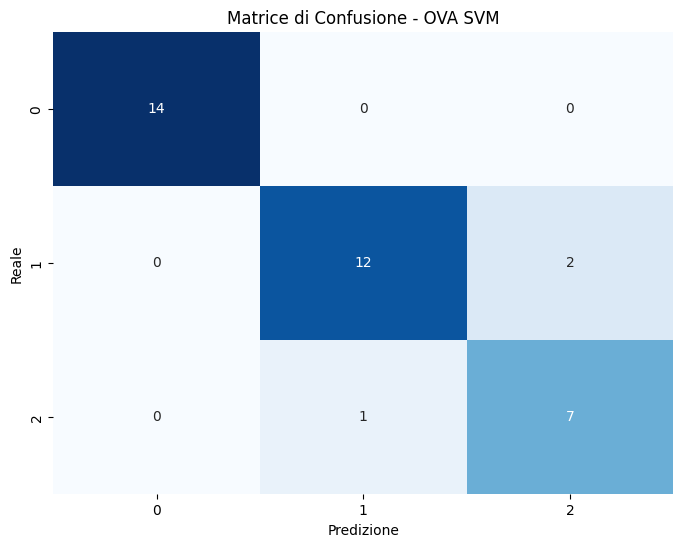

In [16]:
# Addestriamo il modello OVA
svm_ova = SVMMulticlassOVA(svm_class=LinearSVM, C=1.0)
svm_ova.fit(X_train.values, y_train)
# Facciamo predizioni sul test set
y_pred_ova = svm_ova.predict(X_test.values)
# Calcoliamo l'accuratezza
accuracy = accuracy_score(y_test, y_pred_ova)
print(f"Accuratezza del modello OVA sul test: {accuracy:.4f}")
# Visualizziamo la matrice di confusione
cm = confusion_matrix(y_test, y_pred_ova)
plt.figure(figsize=(8, 6))
plt.title('Matrice di Confusione - OVA SVM')
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predizione')
plt.ylabel('Reale')
plt.show()

